from Kaggle:
https://www.kaggle.com/c/dont-overfit-ii/overview

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV

np.random.seed(42)

## O que sabemos sobre o dataset?

In [2]:
overfit_train_data = pd.read_csv('./data/train.csv',index_col='id')
overfit_test_data  = pd.read_csv("./data/test.csv",index_col='id')

print(f"Temos um dataset com {overfit_train_data.shape[1]-1} features")

Temos um dataset com 300 features


In [ ]:
dic = {}
for col in overfit_train_data:
    dic[col] = []
    dic[col].append(len(overfit_train_data[col].unique()))
    dic[col].append(overfit_train_data[col].isnull().sum())
pd.DataFrame.from_dict(data=dic,orient='index',columns=['number','missing values'])

# Resolução com Todas as Features

         Mean        Std   Acc
Log_Reg  69.5  10.111874  82.0


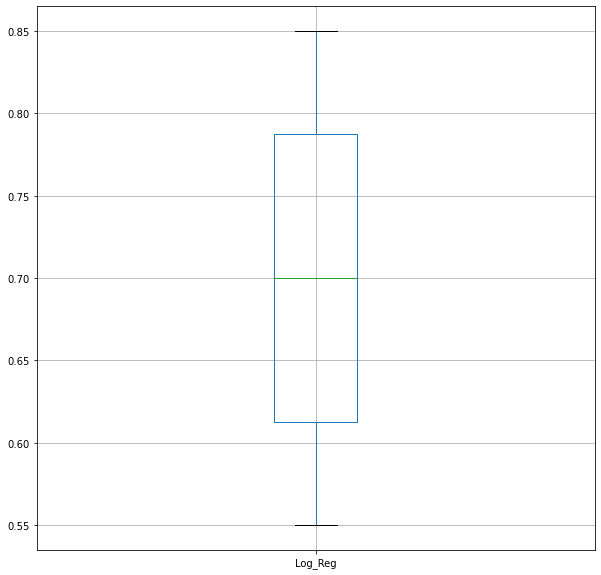

In [14]:
TEST_SIZE = 0.2
STRATEGY_NUM = 'mean'
SCORING = 'accuracy' #'roc_auc' #
N_SPLITS = 10


X = overfit_train_data.drop(columns='target')
y = overfit_train_data.loc[:,'target']

# Antes de mais nada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

# Applying Standard Scaler
NUM_FEAT = X.columns.values
scaler = StandardScaler()
num_transf = Pipeline([('Scaler',scaler)])

preprocessor = ColumnTransformer(transformers=[
    ('Numeric',num_transf,NUM_FEAT)
])

svc = SVC()
log_reg = LogisticRegression(C = 0.1, penalty= 'l1',solver='liblinear') #C=6, #penalty='l2'
                             #class_weight='balanced', #0.1
                             #max_iter=10000,
                             #solver='lbfgs',
                             #n_jobs=-1,
grad_boost = GradientBoostingClassifier()
kfold = KFold(n_splits=N_SPLITS, shuffle=True)

# list models
list_models = [('Log_Reg', log_reg)] #('SVC', svc), , ('Grad_Boost', grad_boost)

df_summary = pd.DataFrame(columns=['Mean','Std','Acc'])
df_scores = pd.DataFrame()

X_final = overfit_test_data

# cross-val, treino e avalicao tudo num for
for name, model in list_models:
    pipe = Pipeline([('Preprocessor', preprocessor), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring=SCORING, cv=kfold)
    df_scores.loc[:, name] = scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    df_summary.loc[name] = [scores.mean()*100, 
                            scores.std()*100,
                           accuracy_score(y_test, y_pred)*100]
    
    # Wrinting the output for Kaggle
    #y_pred_final = pipe.predict(X_final)
    y_pred_final  = pipe.predict_proba(X_final)[:,1]
    output = pd.DataFrame({'id': X_final.index, 'target': y_pred_final})
    output.to_csv(f'./outputs/{name} DontOverfit 2020-11-22.csv',index=False)

print(df_summary)
df_scores.boxplot(figsize=(10, 10))
plt.show()

In [11]:
pipe.predict_proba(X_final)[:,1]

array([0.58433363, 0.06311444, 0.34065459, ..., 0.23079328, 0.03869532,
       0.01015035])

# Com apenas as features selecionadas

In [ ]:
s = overfit_train_data.corr()['target'].sort_values(ascending=False)
selected_columns = s.loc[s>0.1].index.values[1:]

In [ ]:
TEST_SIZE = 0.2
STRATEGY_NUM = 'mean'
SCORING = 'accuracy' #'roc_auc' #
N_SPLITS = 10


X = overfit_train_data[selected_columns]
y = overfit_train_data.loc[:,'target']

# Antes de mais nada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

# Applying Standard Scaler
NUM_FEAT = selected_columns
scaler = StandardScaler()
num_transf = Pipeline([('Scaler',scaler)])

preprocessor = ColumnTransformer(transformers=[
    ('Numeric',num_transf,NUM_FEAT)
])

svc = SVC()
log_reg = LogisticRegression() #C=6, #penalty='l2'
                             #class_weight='balanced', #0.1
                             #max_iter=10000,
                             #solver='lbfgs',
                             #n_jobs=-1,
grad_boost = GradientBoostingClassifier()
kfold = KFold(n_splits=N_SPLITS, shuffle=True)

# list models
list_models = [('SVC', svc), ('Log_Reg', log_reg), ('Grad_Boost', grad_boost)]

df_summary = pd.DataFrame(columns=['Mean','Std','Acc'])
df_scores = pd.DataFrame()

X_final = overfit_test_data[selected_columns]

# cross-val, treino e avalicao tudo num for
for name, model in list_models:
    pipe = Pipeline([('Preprocessor', preprocessor), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring=SCORING, cv=kfold)
    df_scores.loc[:, name] = scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    df_summary.loc[name] = [scores.mean()*100, 
                            scores.std()*100,
                           accuracy_score(y_test, y_pred)*100]
    
    # Wrinting the output for Kaggle
    y_pred_final = pipe.predict(X_final)
    output = pd.DataFrame({'id': X_final.index, 'target': y_pred_final})
    output.to_csv(f'./outputs/{name} DontOverfit Few Columns 2020-11-22.csv',index=False)

print(df_summary)
df_scores.boxplot(figsize=(10, 10))
plt.show()

# Excluindo e Normalizando

In [ ]:
TEST_SIZE = 0.2
STRATEGY_NUM = 'mean'
SCORING = 'accuracy' #'roc_auc' #
N_SPLITS = 10


X = overfit_train_data.drop(columns='target')
y = overfit_train_data.loc[:,'target']

# Antes de mais nada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

# Applying Standard Scaler
NUM_FEAT = X.columns.values
selector = VarianceThreshold(threshold=0.0)
scaler = StandardScaler()
num_transf = Pipeline([('Select',selector),('Scaler',scaler)])

preprocessor = ColumnTransformer(transformers=[
    ('Numeric',num_transf,NUM_FEAT)
])

svc = SVC()
log_reg = LogisticRegression() #C=6, #penalty='l2'
                             #class_weight='balanced', #0.1
                             #max_iter=10000,
                             #solver='lbfgs',
                             #n_jobs=-1,
grad_boost = GradientBoostingClassifier()
kfold = KFold(n_splits=N_SPLITS, shuffle=True)

# list models
list_models = [('SVC', svc), ('Log_Reg', log_reg), ('Grad_Boost', grad_boost)]

df_summary = pd.DataFrame(columns=['Mean','Std','Acc'])
df_scores = pd.DataFrame()

X_final = overfit_test_data

# cross-val, treino e avalicao tudo num for
for name, model in list_models:
    pipe = Pipeline([('Preprocessor', preprocessor), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring=SCORING, cv=kfold)
    df_scores.loc[:, name] = scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    df_summary.loc[name] = [scores.mean()*100, 
                            scores.std()*100,
                           accuracy_score(y_test, y_pred)*100]
    
    # Wrinting the output for Kaggle
    y_pred_final = pipe.predict(X_final)
    output = pd.DataFrame({'id': X_final.index, 'target': y_pred_final})
    output.to_csv(f'./outputs/{name} Selector DontOverfit 2020-11-22.csv',index=False)

print(df_summary)
df_scores.boxplot(figsize=(10, 10))
plt.show()